# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier 为Softmax分类器实现完全矢量化的损失函数
- implement the fully-vectorized expression for its **analytic gradient** 为其分析梯度实现完全矢量化表达式
- **check your implementation** with numerical gradient 用数值梯度检查你的实现
- use a validation set to **tune the learning rate and regularization** strength 使用验证集来调整学习速率和规则化强度
- **optimize** the loss function with **SGD** 用梯度下降优化损失函数
- **visualize** the final learned weights 可视化最终学到的权重矩阵W


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function. 
  从磁盘加载CIFAR-10数据集并执行预处理，为线性分类器做好准备。 这些步骤与我们用于SVM的步骤相同，只是简化为一个函数。
  """
  # Load the raw CIFAR-10 data 加载数据
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data 抽样
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows 预处理，把每张图都变成一行
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image 标准化数据：减去平均图像
  mean_image = np.mean(X_train, axis = 0) #按列，求均值，相当于求每张图片同样位置的像素点的均值
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns 加上一个偏置维度，并转换成一列
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.首先使用嵌套循环实现朴素的softmax的loss函数。
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0) #softmax 得到的loss和grad

# As a rough sanity check, our loss should be something close to -log(0.1).#为什么呢，因为是 -log(e^0/10*e^0)
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.351074
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** **为什么呢，因为是 -log(e^0/10*e^0) 一开始的矩阵W是0呗，所以乘出来的score都是0**


In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.650701 analytic: -0.650701, relative error: 1.748653e-08
numerical: 2.238155 analytic: 2.238155, relative error: 2.362945e-08
numerical: -0.045287 analytic: -0.045287, relative error: 2.174919e-07
numerical: 0.436701 analytic: 0.436701, relative error: 5.688139e-08
numerical: -0.419191 analytic: -0.419191, relative error: 6.505051e-08
numerical: 1.004351 analytic: 1.004350, relative error: 5.624805e-09
numerical: -0.626885 analytic: -0.626885, relative error: 2.342906e-08
numerical: -2.821745 analytic: -2.821745, relative error: 4.405338e-09
numerical: 2.641353 analytic: 2.641353, relative error: 2.636264e-08
numerical: 3.615546 analytic: 3.615545, relative error: 2.036604e-08
numerical: 1.667516 analytic: 1.667516, relative error: 1.409114e-08
numerical: 0.077491 analytic: 0.077491, relative error: 1.713400e-07
numerical: -0.280812 analytic: -0.280812, relative error: 3.816011e-08
numerical: 2.257549 analytic: 2.257549, relative error: 1.687353e-08
numerical: 2.871648 an

In [40]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
# ＃现在我们已经对softmax损失函数及其梯度进行了简单的实现，
# ＃在softmax_loss_vectorized中实现矢量化版本。
# ＃这两个版本应该计算相同的结果，但向量化版本应该更快。

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.351074e+00 computed in 0.114366s
vectorized loss: 2.351074e+00 computed in 0.006411s
Loss difference: 0.000000
Gradient difference: 0.000000


In [54]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# ＃使用验证集来调整超参数（正则化强度和
# ＃学习率）。 你应该尝试不同的学习范围
# ＃率和正规化优势; 如果你小心你应该能够
# ＃验证集上的分类准确度超过0.35。
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]

regularization_strengths = [1e-2,1e-1,1e1,1e2,1e3,1e4,1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
#使用验证集来设置学习率和正则化强度。这应该与您为SVM所做的验证相同; 在best_softmax中保存训练有素的softmax分类器。＃
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        new_softmax = Softmax()
        new_softmax.train(X_train,y_train,learning_rate = lr, reg = rs, num_iters = 2000,verbose=True)
        y_train_pred = new_softmax.predict(X_train)
        y_val_pred = new_softmax.predict(X_val)
        
        y_train_acc = np.mean(y_train_pred == y_train)
        y_val_acc = np.mean(y_val_pred == y_val)
        
        results[(lr,rs)] = [y_train_acc,y_val_acc]
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = new_softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 2000: loss 5.840743
iteration 100 / 2000: loss 4.024733
iteration 200 / 2000: loss 3.946124
iteration 300 / 2000: loss 3.490052
iteration 400 / 2000: loss 3.439218
iteration 500 / 2000: loss 3.267205
iteration 600 / 2000: loss 3.242194
iteration 700 / 2000: loss 3.125927
iteration 800 / 2000: loss 2.892485
iteration 900 / 2000: loss 2.710057
iteration 1000 / 2000: loss 3.042751
iteration 1100 / 2000: loss 2.836594
iteration 1200 / 2000: loss 2.767563
iteration 1300 / 2000: loss 2.712989
iteration 1400 / 2000: loss 2.702870
iteration 1500 / 2000: loss 2.608222
iteration 1600 / 2000: loss 2.849400
iteration 1700 / 2000: loss 2.543052
iteration 1800 / 2000: loss 2.621431
iteration 1900 / 2000: loss 2.558339
iteration 0 / 2000: loss 5.906929
iteration 100 / 2000: loss 3.800450
iteration 200 / 2000: loss 3.994946
iteration 300 / 2000: loss 3.497711
iteration 400 / 2000: loss 3.178906
iteration 500 / 2000: loss 3.092421
iteration 600 / 2000: loss 3.004150
iteration 700 / 2000: 

iteration 400 / 2000: loss 8.828592
iteration 500 / 2000: loss 7.420970
iteration 600 / 2000: loss 6.428801
iteration 700 / 2000: loss 5.416846
iteration 800 / 2000: loss 4.790932
iteration 900 / 2000: loss 4.142784
iteration 1000 / 2000: loss 3.762074
iteration 1100 / 2000: loss 3.415621
iteration 1200 / 2000: loss 3.215049
iteration 1300 / 2000: loss 2.848777
iteration 1400 / 2000: loss 2.564326
iteration 1500 / 2000: loss 2.395145
iteration 1600 / 2000: loss 2.512030
iteration 1700 / 2000: loss 2.207459
iteration 1800 / 2000: loss 2.218307
iteration 1900 / 2000: loss 2.064552
iteration 0 / 2000: loss 159.703692
iteration 100 / 2000: loss 22.392269
iteration 200 / 2000: loss 4.602472
iteration 300 / 2000: loss 2.336950
iteration 400 / 2000: loss 1.970504
iteration 500 / 2000: loss 1.927208
iteration 600 / 2000: loss 1.957106
iteration 700 / 2000: loss 1.911908
iteration 800 / 2000: loss 1.868489
iteration 900 / 2000: loss 2.029050
iteration 1000 / 2000: loss 1.963571
iteration 1100 /

iteration 800 / 2000: loss 41.155845
iteration 900 / 2000: loss 29.059747
iteration 1000 / 2000: loss 28.551775
iteration 1100 / 2000: loss 17.094645
iteration 1200 / 2000: loss 30.686228
iteration 1300 / 2000: loss 42.980696
iteration 1400 / 2000: loss 29.246170
iteration 1500 / 2000: loss 23.500921
iteration 1600 / 2000: loss 23.898228
iteration 1700 / 2000: loss 16.918527
iteration 1800 / 2000: loss 25.206306
iteration 1900 / 2000: loss 40.726118
iteration 0 / 2000: loss 5.085610
iteration 100 / 2000: loss 30.496785
iteration 200 / 2000: loss 33.262348
iteration 300 / 2000: loss 28.116274
iteration 400 / 2000: loss 28.734979
iteration 500 / 2000: loss 30.731258
iteration 600 / 2000: loss 21.848528
iteration 700 / 2000: loss 30.424285
iteration 800 / 2000: loss 36.717624
iteration 900 / 2000: loss 23.563032
iteration 1000 / 2000: loss 25.471215
iteration 1100 / 2000: loss 26.419522
iteration 1200 / 2000: loss 32.295683
iteration 1300 / 2000: loss 21.143206
iteration 1400 / 2000: loss

iteration 200 / 2000: loss inf
iteration 300 / 2000: loss inf


cs231n/classifiers/softmax.py:77: RuntimeWarning: overflow encountered in subtract
  print scores.shape,np.max(scores,axis = 1).reshape((num_train,1)).shape
cs231n/classifiers/softmax.py:77: RuntimeWarning: invalid value encountered in subtract
  print scores.shape,np.max(scores,axis = 1).reshape((num_train,1)).shape


iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 1545.377860
iteration 100 / 2000: loss inf
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2

In [55]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.394000


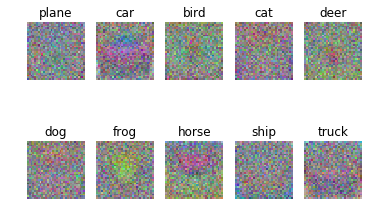

In [57]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])